In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Step 1: Load modified dataset
df = pd.read_csv('dataset_modified.csv')

# Step 2: Define features and target
feature_cols = [c for c in df.columns if c.startswith('fg_') or c.startswith('n_')]
target = 'H'  # predicting enthalpy
X = df[feature_cols]
y = df[target]



In [3]:
# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [4]:

# Step 4: Set up pipelines
ridge_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge())
])
rf_pipe = Pipeline([
    ('scaler', StandardScaler()),  # not strictly needed for RF
    ('model', RandomForestRegressor(random_state=42))
])



In [5]:
# Step 5: Hyperparameter tuning setup
ridge_params = {'model__alpha': [0.01, 0.1, 1.0, 10.0]}
rf_params = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 10],
    'model__min_samples_leaf': [1, 3]
}

ridge_search = GridSearchCV(ridge_pipe, ridge_params, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
rf_search = GridSearchCV(rf_pipe, rf_params, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

# Step 6: Fit models
ridge_search.fit(X_train, y_train)
rf_search.fit(X_train, y_train)




GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [None, 10],
                         'model__min_samples_leaf': [1, 3],
                         'model__n_estimators': [100, 200]},
             scoring='neg_mean_absolute_error')

In [6]:
# Step 7: Evaluate on test set
def evaluate(name, model, X_t, y_t):
    y_pred = model.predict(X_t)
    mae = mean_absolute_error(y_t, y_pred)
    rmse = np.sqrt(mean_squared_error(y_t, y_pred))
    r2 = r2_score(y_t, y_pred)
    print(f"{name}: MAE={mae:.3f}, RMSE={rmse:.3f}, R²={r2:.3f}")

print("Test Set Performance:")
evaluate('Ridge Regression', ridge_search.best_estimator_, X_test, y_test)
evaluate('Random Forest', rf_search.best_estimator_, X_test, y_test)


Test Set Performance:
Ridge Regression: MAE=0.013, RMSE=0.019, R²=1.000
Random Forest: MAE=0.075, RMSE=0.647, R²=1.000


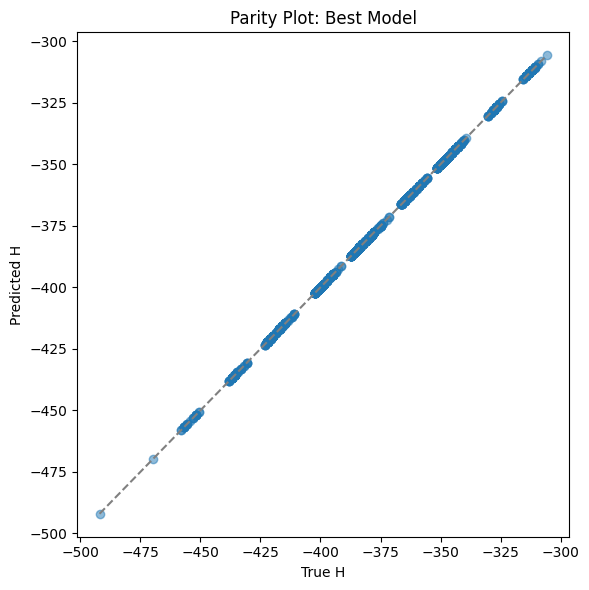

In [7]:
# Step 8: Parity Plot for best model
best_model = rf_search.best_estimator_ if rf_search.best_score_ > ridge_search.best_score_ else ridge_search.best_estimator_
plt.figure(figsize=(6,6))
plt.scatter(y_test, best_model.predict(X_test), alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', color='grey')
plt.xlabel('True H')
plt.ylabel('Predicted H')
plt.title('Parity Plot: Best Model')
plt.tight_layout()
plt.show()

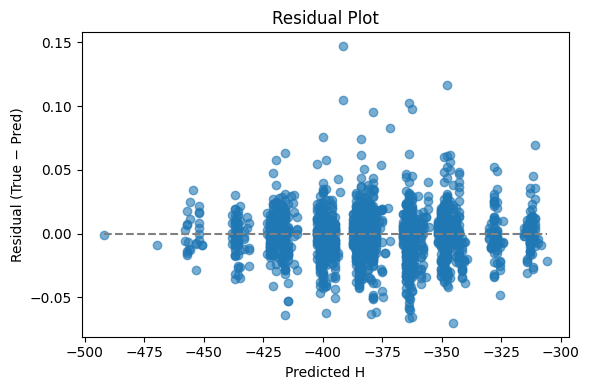

In [8]:
y_pred = best_model.predict(X_test)
residuals = y_test - y_pred

plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.hlines(0, y_pred.min(), y_pred.max(), colors='grey', linestyles='--')
plt.xlabel('Predicted H')
plt.ylabel('Residual (True − Pred)')
plt.title('Residual Plot')
plt.tight_layout()
plt.show()

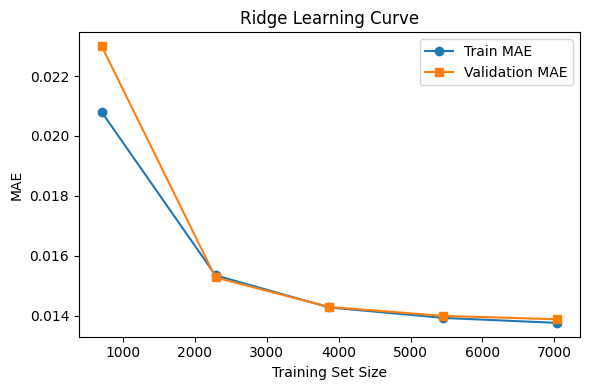

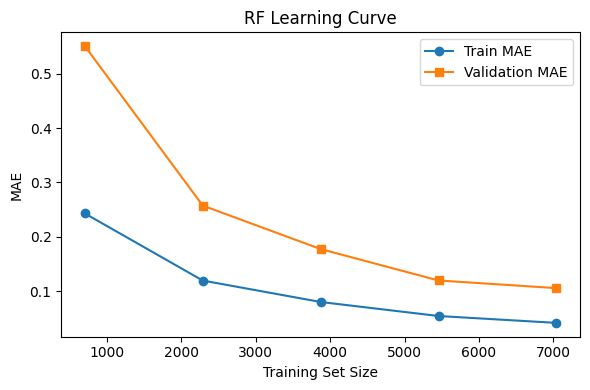

In [12]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
import numpy as np

def plot_learning_curve(estimator, X, y, title="Learning Curve"):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator,
        X, y,
        cv=5,
        scoring='neg_mean_absolute_error',
        train_sizes=np.linspace(0.1, 1.0, 5),
        n_jobs=-1
    )
    train_mae = -train_scores.mean(axis=1)
    val_mae   = -val_scores.mean(axis=1)

    plt.figure(figsize=(6,4))
    plt.plot(train_sizes, train_mae, marker='o', label='Train MAE')
    plt.plot(train_sizes, val_mae  , marker='s', label='Validation MAE')
    plt.xlabel('Training Set Size')
    plt.ylabel('MAE')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage:
plot_learning_curve(ridge_search.best_estimator_, X_train, y_train, title="Ridge Learning Curve")
plot_learning_curve(rf_search.best_estimator_,    X_train, y_train, title="RF Learning Curve")
